In [1]:
# Importation
# Link: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [16]:
file_name = 'shampoo.csv'
df = pd.read_csv(file_name, parse_dates = ['Month'], index_col = ['Month'])
df.head()

,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


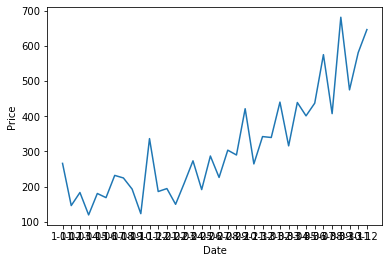

In [17]:
# Reading the file and plotting the basics
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df)

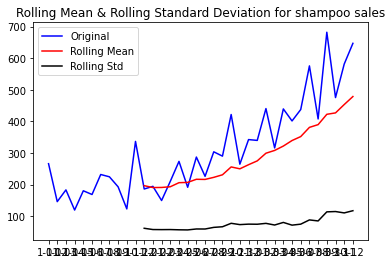

In [18]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std() #Used for standard deviation
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation for shampoo sales')
plt.show()

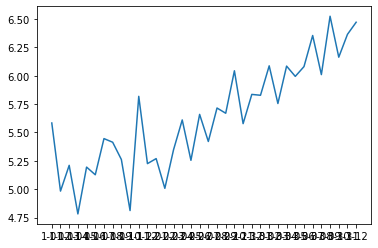

In [19]:
df_log = np.log(df)
plt.plot(df_log)

In [20]:
# Checking if a timeseries is stationary or not
# Stationary: The mean of the series should not grow over time, the variance of the series should not spread over time, and the convariance of'i'th and (i + m)th should not be a funtion of time 
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Sales'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

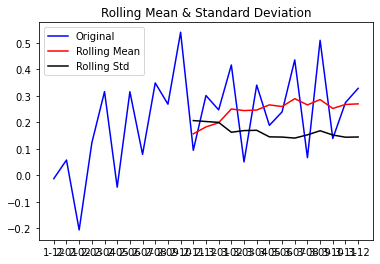

ADF Statistic: -2.8666384708515986
p-value: 0.04936730550579396
Critical Values:
	1%: -3.9240193847656246
	5%: -3.0684982031250003
	10%: -2.67389265625


In [21]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

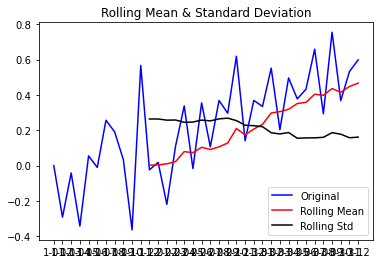

ADF Statistic: -0.9453530717367268
p-value: 0.7726705008438277
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004


In [22]:
# Used to turn the timeframe into a stationary one
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

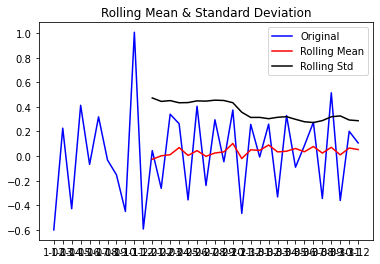

ADF Statistic: -2.1682021458141496
p-value: 0.2179879382560318
Critical Values:
	1%: -3.7377092158564813
	5%: -2.9922162731481485
	10%: -2.635746736111111


In [23]:
# Another method to determine if there is a better method to turn a moving time series into a stationary one
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [32]:
decomposition = seasonal_decompose(df_log, period=1) 
#decomposition = seasonal_decompose(x=df_log, model='additive', extrapolate_trend='freq', period=1) 
model = ARIMA(df_log, order=(0,1,2))
# DOn't know what the hell i did, but i changed the arima format (p,d,q) from (2,1,2) to (0,1,2)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [33]:
results = model.fit(disp=-1)

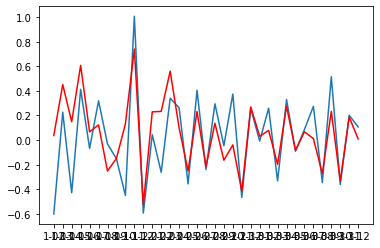

In [34]:
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

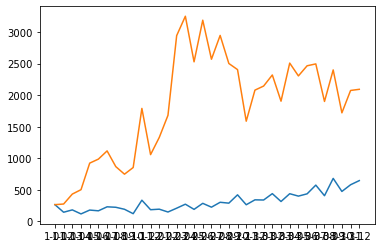

In [36]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Sales'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


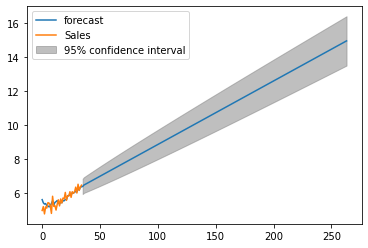

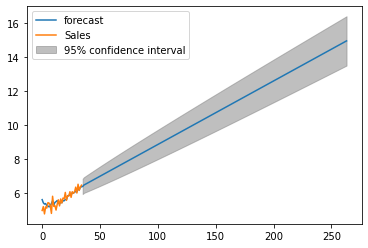

In [37]:
results.plot_predict(1,264)